In [1]:
#file name: tourism.ipynb
#author: Solange  
#Objective: To predict which customer is more likely to purchase the newly introduced travel package.
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBRegressor #<-this requires library install

In [2]:
# Two sample t-test for comparing mean

import scipy.stats as st
#Lets define some useful stats quantities for analysis
def ssdev(X):
    xbar = np.mean(X)
    s= sum([(x-xbar)**2 for x in X])
    ssd =( s / (len(X)-1) )**.5
    return ssd
def tstat(xb1, xb2, ss1, ss2, n1, n2):
    #this is a rough estimator and not using pooled t-test
    print("tstat: xb1, xb2, ss1, ss2, n1, n2 ")
    print(str([xb1, xb2, ss1, ss2, n1, n2]) )
    SE = (ss1**2/n1 + ss2**2/n2)**.5
    ts = (xb1 - xb2)/SE
    return ts
def twos_twotail_ttest(Samp1, Samp2, sig):
    x_bar_1 = np.mean(Samp1)
    x_bar_2 = np.mean(Samp2)
    ssdev_1 = ssdev(Samp1)
    ssdev_2 = ssdev(Samp2)
#the degrees of freedom is the smaller of the two n1-1 and n2-1
    df_12 = min(len(Samp1), len(Samp2)) -1
    #print the critical values designating the ending and beginning of rejection region
    print(st.t.interval(alpha=(1-sig), df=df_12, loc=0, scale=1) )
#lastly, calculate the t-stsat
    t_s = tstat(x_bar_1, x_bar_2, ssdev_1, ssdev_2, len(Samp1), len(Samp2))
    print(t_s)

In [3]:
def zstat(x1, x2, n1, n2):
    p1 = x1/n1
    p2 = x2/n2
    pooled_prop = (p1*n1+p2*n2)/(n1+n2)
    SE = (pooled_prop*(1-pooled_prop)*(1/n1+1/n2))**.5
    z_stat = (p1-p2)/SE
    return z_stat
def twoprop_twotail_z(Samp1, Samp2, sig):
    #note Samp1 and Samp2 are assumed to have binary value 0 or 1
    print(st.norm.interval(alpha=(1-sig), loc=0, scale=1) )
    z_s = zstat(sum(Samp1), sum(Samp2), len(Samp1), len(Samp2))
    print(z_s)

In [4]:
#Specify and open/read the raw data file to DataFrame
tourism_data_file_reference = "tourism.csv"
tourism_data = pd.read_csv(tourism_data_file_reference)

In [5]:
#Checking that the import was successful and previewing which data need to be cleaned
tourism_data.describe()

,CustomerID,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
count,4888.000000,4888.000000,4662.000000,4888.000000,4637.000000,4888.000000,4843.000000,4862.000000,4748.000000,4888.000000,4888.000000,4888.000000,4822.000000,4655.000000
mean,202443.500000,0.188216,37.622265,1.654255,15.490835,2.905074,3.708445,3.581037,3.236521,0.290917,3.078151,0.620295,1.187267,23619.853491
std,1411.188388,0.390925,9.316387,0.916583,8.519643,0.724891,1.002509,0.798009,1.849019,0.454232,1.365792,0.485363,0.857861,5380.698361
min,200000.000000,0.000000,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000
25%,201221.750000,0.000000,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20346.000000
50%,202443.500000,0.000000,36.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22347.000000
75%,203665.250000,0.000000,44.000000,3.000000,20.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25571.000000
max,204887.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,5.000000,1.000000,3.000000,98678.000000


In [6]:
tourism_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [7]:
tourism_data.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [8]:
#The ProdTaken column is the one we are trying to predict using the binary classifier models 
# Age, DurationOfPitch, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, 
# NumberOfChildrenVisiting, MonthlyIncome
#Dropping two columns from the dataframe

#Firstly, customer id is an unhelpful index (not helpful for prediction)
tourism_data.drop(columns=['CustomerID'], inplace=True)

In [9]:
#Pull all columns excetp the response 
tourism_cols = tourism_data.columns.tolist()
tourism_cols.remove('ProdTaken')
print(tourism_cols)

['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome']


In [10]:
#remove the ones that are nan
copy_tourism_data = tourism_data.dropna()

In [11]:
#Divide using train test split
y = copy_tourism_data["ProdTaken"]
X = copy_tourism_data[tourism_cols]#independent variables
X_train, X_val, y_train, y_val= train_test_split(X, y,random_state = 0)

In [12]:
# Get list of categorical variables
#https://www.kaggle.com/alexisbcook/categorical-variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']


In [13]:
#Next Use One-Hot encoder to turn categorical columns into encoded values

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_val[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_val.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_val.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

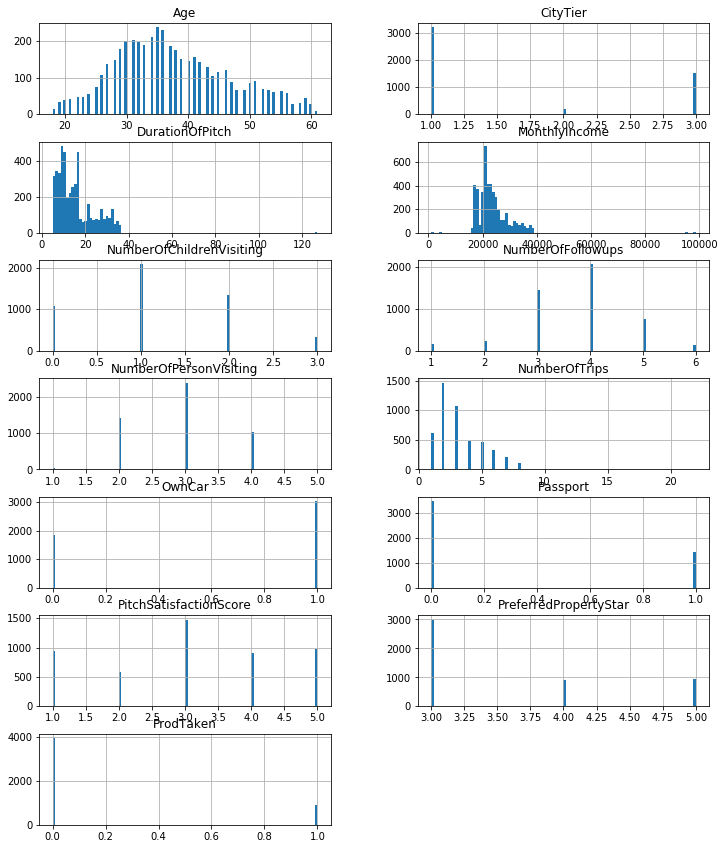

In [14]:
#Visualize the distributions of all data
tourism_data.hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

In [15]:
#Looking For Correlations to See what might be useful to test
# However we want to see correlation in graphical representation so below is function for that
import numpy as np
def plot_corr(df, size=11):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

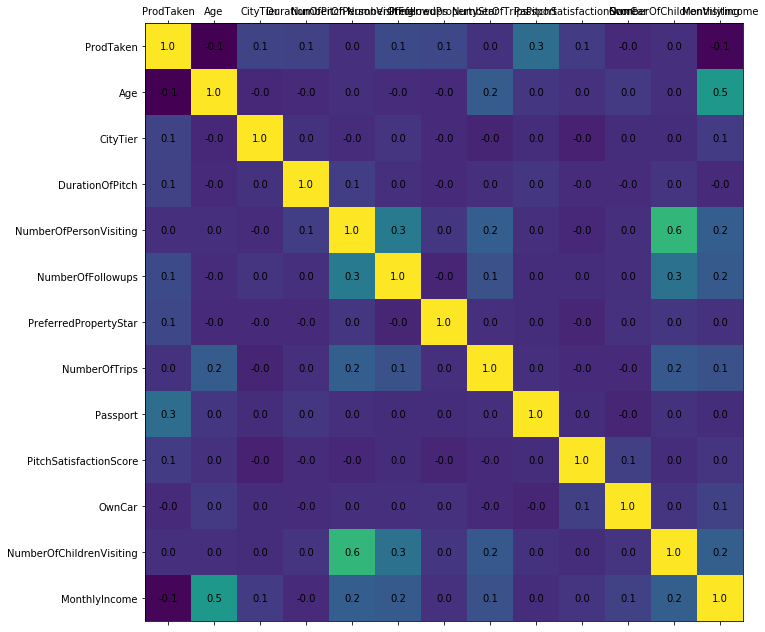

In [16]:
plot_corr(tourism_data)

In [17]:
#Scrub Duration of Pitch, Number of Trips, MonthlyIncome of Outliers
#Outlier Cutoffs
#It is more useful to visualize and generate regresion from KM_Driven that does not contain outliers
quantitative=['DurationOfPitch','NumberOfTrips','MonthlyIncome']
seventy_fifth=[20.000000, 	4.000000, 25571.000000]
twenty_fifth=[9.000000, 2.000000, 20346.000000]
cutoffs, upperco, lowerco =[],[],[]
for i in range(len(seventy_fifth)): cutoffs.append( (seventy_fifth[i] - twenty_fifth[i])*1.5 ) 
for i in range(len(seventy_fifth)): upperco.append( seventy_fifth[i] + cutoffs[i] ) 
for i in range(len(seventy_fifth)): lowerco.append( twenty_fifth[i] - cutoffs[i] ) 

print("Outliers fall below:")

print(lowerco)
print("Outliers extend above:")
print(upperco)

print(quantitative)
#you will see that though it doesn't make sense to cal outlier by S.No 
#outliers exist for Year, Kilometers Driven, Seats and Price 

Outliers fall below:
[-7.5, -1.0, 12508.5]
Outliers extend above:
[36.5, 7.0, 33408.5]
['DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']


In [18]:
#Using Appended concatinated set for the analyses
y_train.append(y_val)
OH_X_train.append(OH_X_valid)
clean_tourism_data = pd.concat([y_train,OH_X_train], axis=1)

In [19]:
wout_MI_outliers, MI_outlieres =  [x for _, x in clean_tourism_data.groupby(tourism_data['MonthlyIncome'] < 12508.5)]
wout_MI_outliers, MI_outlieres =  [x for _, x in wout_MI_outliers.groupby(wout_MI_outliers['MonthlyIncome'] > 33408.5)]
wout_NT_outliers, NT_outlieres =  [x for _, x in wout_MI_outliers.groupby(wout_MI_outliers['NumberOfTrips'] > 7 )]
wout_DoP_outliers, DoP_outlieres =  [x for _, x in wout_NT_outliers.groupby(wout_NT_outliers['DurationOfPitch'] > 36.5 )]

In [20]:
#__________DATA CLEANED, SPLIT BY RESPONSE
df_prodtaken_y, df_prodtaken_n = [x for _, x in wout_DoP_outliers.groupby(wout_DoP_outliers['ProdTaken'] == 0)]

In [21]:
df_prodtaken_y.describe()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,...,13,14,15,16,17,18,19,20,21,22
count,557.0,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,...,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000
mean,1.0,34.147217,1.834829,17.418312,2.933573,3.938959,3.761221,3.154399,0.549372,3.238779,...,0.017953,0.131059,0.350090,0.310592,0.208259,0.017953,0.606822,0.215440,0.157989,0.001795
std,0.0,9.912379,0.960370,8.568968,0.705250,0.976269,0.860026,1.704164,0.498004,1.340596,...,0.132901,0.337768,0.477427,0.463152,0.406428,0.132901,0.488895,0.411497,0.365059,0.042371
min,1.0,18.000000,1.000000,6.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,27.000000,1.000000,10.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,32.000000,1.000000,15.000000,3.000000,4.000000,3.000000,3.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.0,40.000000,3.000000,24.000000,3.000000,5.000000,5.000000,4.000000,1.000000,4.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.0,59.000000,3.000000,36.000000,4.000000,6.000000,5.000000,7.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df_prodtaken_n.describe()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,...,13,14,15,16,17,18,19,20,21,22
count,2370.0,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,...,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,0.0,37.600000,1.629114,15.335865,2.954430,3.691561,3.530802,3.173418,0.236709,3.007595,...,0.066245,0.206329,0.504641,0.129958,0.159072,0.066245,0.341350,0.397046,0.191139,0.004219
std,0.0,8.714621,0.911210,8.231370,0.726127,0.987796,0.768263,1.590618,0.425152,1.352243,...,0.248762,0.404755,0.500084,0.336328,0.365820,0.248762,0.474263,0.489389,0.393281,0.064833
min,0.0,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,36.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,43.000000,3.000000,19.000000,3.000000,4.000000,4.000000,4.000000,0.000000,4.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,0.0,61.000000,3.000000,36.000000,5.000000,6.000000,5.000000,7.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


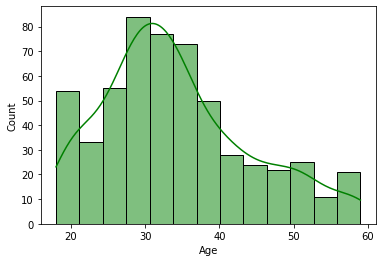

In [23]:
#Age
sns.histplot(df_prodtaken_y['Age'], kde=True, color='green')

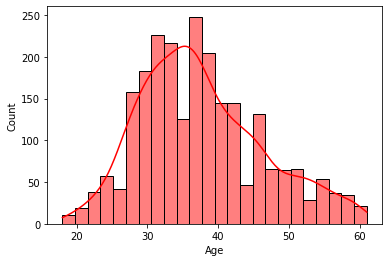

In [24]:
sns.histplot(df_prodtaken_n['Age'], kde=True, color='red')

In [25]:
#Ages can be assumed to be roughly normal and independent of one another
#H0 : mean age is the same between package status
#H1 : mean age is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['Age'], df_prodtaken_y['Age'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[37.6, 34.147217235188506, 8.714620931645323, 9.912379458175925, 2370, 557]
7.562641869092792


In [26]:
#7.9 for the t statistic is outside the range therefore the means are statistically different

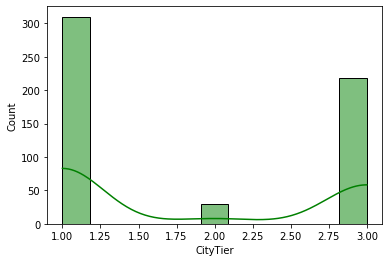

In [27]:
#CityTeir
sns.histplot(df_prodtaken_y['CityTier'], kde=True, color='green')

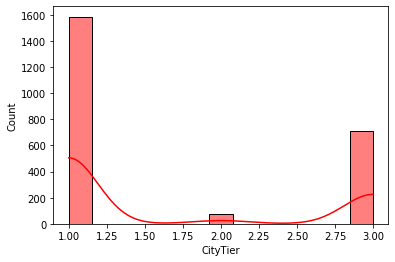

In [28]:
sns.histplot(df_prodtaken_n['CityTier'], kde=True, color='red')

In [29]:
#The two prop z can be used on City teir, npq>10 and binomial situation is '=1' success, 
# with '!=1' fail
#H0 : prop city teir is the same between package status 
#H1 : prop city teir different between package status
# significance = .05
nCT_is1, nCT_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n['CityTier'] != 1)]
nencodeCT = [1]*len(nCT_is1['CityTier'])
nencodeCT.extend([0]*len(nCT_isnt1))
yCT_is1, yCT_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y['CityTier'] != 1)]
yencodeCT = [1]*len(yCT_is1['CityTier'])
yencodeCT.extend([0]*len(yCT_isnt1))
twoprop_twotail_z(nencodeCT, yencodeCT, .05)#(df_prodtaken_n['CityTier'], df_prodtaken_y['CityTier'], sig)

(-1.959963984540054, 1.959963984540054)
5.008156609423943


In [30]:
#therefore, city tier is statistically different

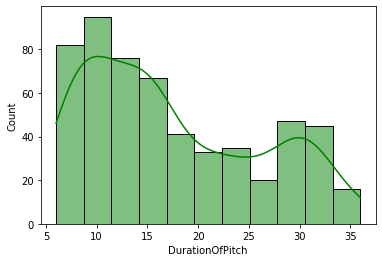

In [31]:
#DurationOfPitch
sns.histplot(df_prodtaken_y['DurationOfPitch'], kde=True, color='green')

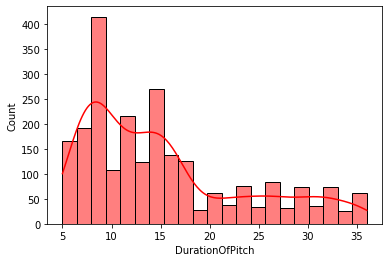

In [32]:
sns.histplot(df_prodtaken_n['DurationOfPitch'], kde=True, color='red')

In [33]:
#DurationOfPitch
#The two prop z can be used on DurationOfPitch, npq>10 and binomial situation is '<20' success, 
# with '>=20' fail
#H0 : prop DurationOfPitch is the same between package status 
#H1 : prop DurationOfPitch different between package status
# significance = .05
DoP = 'DurationOfPitch'
nDoP_isunder20, nDoP_isntunder20 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[DoP] >= 20)]
nencode_DoP = [1]*len(nDoP_isunder20[DoP])
nencode_DoP.extend([0]*len(nDoP_isntunder20))
yDoP_isunder20, yDoP_isntunder20 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[DoP] >= 20)]
yencode_DoP = [1]*len(yDoP_isunder20[DoP])
yencode_DoP.extend([0]*len(yDoP_isntunder20))
twoprop_twotail_z(nencode_DoP, yencode_DoP, .05)

(-1.959963984540054, 1.959963984540054)
4.888252740790541


In [34]:
#therefore, Duration of Pitch is statistically different

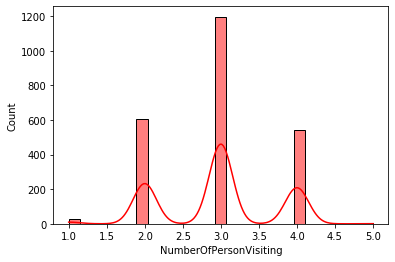

In [35]:
#NumberOfPersonVisiting
sns.histplot(df_prodtaken_n['NumberOfPersonVisiting'], kde=True, color='red')

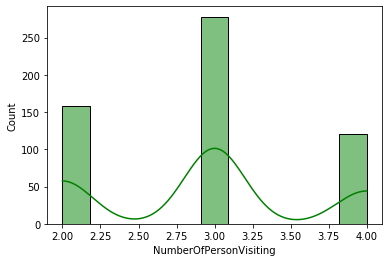

In [36]:
sns.histplot(df_prodtaken_y['NumberOfPersonVisiting'], kde=True, color='green')

In [37]:
#Number of Person Visiting can be assumed to be roughly normal and independent of one another
#H0 : mean Numberof Persons Visiting is the same between package status
#H1 : mean Numberof Persons Visiting is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['NumberOfPersonVisiting'], df_prodtaken_y['NumberOfPersonVisiting'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[2.9544303797468356, 2.933572710951526, 0.726126577294003, 0.7052503386154999, 2370, 557]
0.6245171353472931


In [38]:
#Number of Person Visiting is therefore not statistically impactful

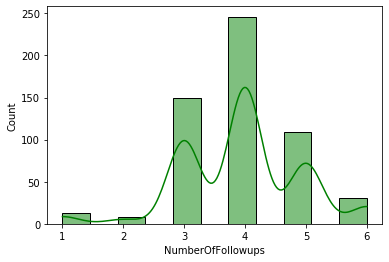

In [39]:
#NumberOfFollowups
sns.histplot(df_prodtaken_y['NumberOfFollowups'], kde=True, color='green')

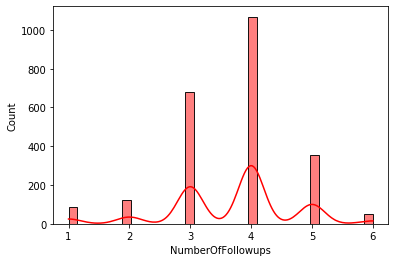

In [40]:
sns.histplot(df_prodtaken_n['NumberOfFollowups'], kde=True, color='red')

In [41]:
#number of followups can be assumed to be roughly normal and independent of one another
#H0 : mean number of followups is the same between package status
#H1 : mean number of followups is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['NumberOfFollowups'], df_prodtaken_y['NumberOfFollowups'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[3.691561181434599, 3.938958707360862, 0.987796201363374, 0.9762693232184035, 2370, 557]
-5.369536194779739


In [42]:
#number of followups is statistically different 

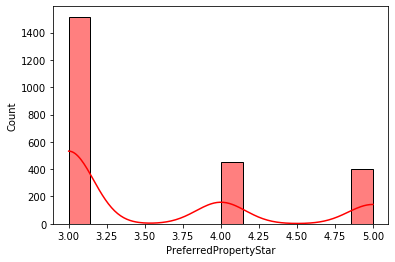

In [43]:
#PreferredPropertyStar
sns.histplot(df_prodtaken_n['PreferredPropertyStar'], kde=True, color='red')

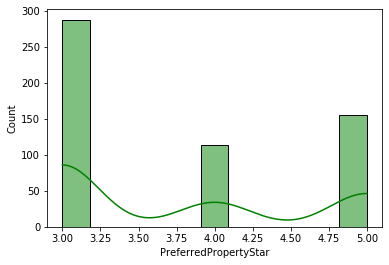

In [44]:
sns.histplot(df_prodtaken_y['PreferredPropertyStar'], kde=True, color='green')

In [45]:
#PreferredPropertyStar
#The two prop z can be used on DurationOfPitch, npq>10 and binomial situation is '=3' success, 
# with '>=4' fail
#H0 : prop DurationOfPitch is the same between package status 
#H1 : prop DurationOfPitch different between package status
# significance = .05
PPS = 'PreferredPropertyStar'
nPPS_isunder4, nPPS_isntunder4 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[PPS] != 3)]
nencode_PPS = [1]*len(nPPS_isunder4[PPS])
nencode_PPS.extend([0]*len(nPPS_isntunder4))
yPPS_isunder4, yPPS_isntunder4 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[PPS] != 3)]
yencode_PPS = [1]*len(yPPS_isunder4[PPS])
yencode_PPS.extend([0]*len(yPPS_isntunder4))
twoprop_twotail_z(nencode_PPS, yencode_PPS, .05)

(-1.959963984540054, 1.959963984540054)
5.354507315201065


In [46]:
#Reject null, the Prefered Property Star Is different between groups

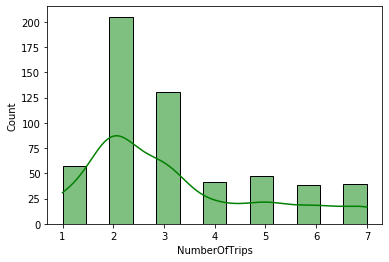

In [47]:
#NumberOfTrips
sns.histplot(df_prodtaken_y['NumberOfTrips'], kde=True, color='green')

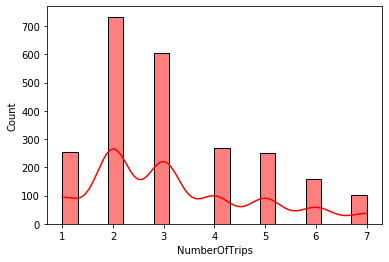

In [48]:
sns.histplot(df_prodtaken_n['NumberOfTrips'], kde=True, color='red')

In [49]:
#NumberOfTrips
#The two prop z can be used on NumberOfTrips, npq>10 and binomial situation is '<5' success, 
# with '>=5' fail
#H0 : prop NumberOfTrips is the same between package status 
#H1 : prop NumberOfTrips different between package status
# significance = .05
NOT = 'NumberOfTrips'
nNOT_isunder5, nNOT_isntunder5 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[NOT] >= 5)]
nencode_NOT = [1]*len(nNOT_isunder5[NOT])
nencode_NOT.extend([0]*len(nNOT_isntunder5))
yNOT_isunder5, yNOT_isntunder5 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[NOT] >= 5)]
yencode_NOT = [1]*len(yNOT_isunder5[NOT])
yencode_NOT.extend([0]*len(yNOT_isntunder5))
twoprop_twotail_z(nencode_NOT, yencode_NOT, .05)

(-1.959963984540054, 1.959963984540054)
0.38311745730893587


In [50]:
#Number of trip is not statistically significant

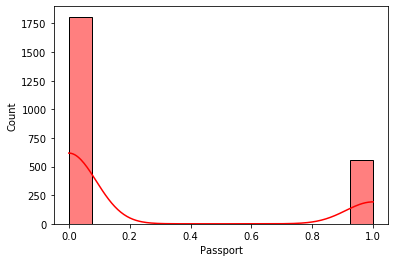

In [51]:
#Passport
sns.histplot(df_prodtaken_n['Passport'], kde=True, color='red')

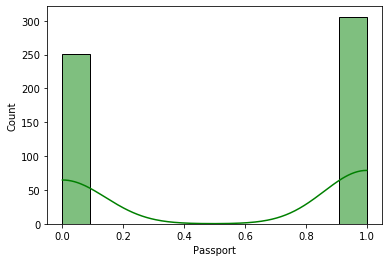

In [52]:
sns.histplot(df_prodtaken_y['Passport'], kde=True, color='green')

In [53]:
#Passport
#The two prop z can be used on PPassport, npq>10 and binomial situation is '=1' success, 
# with '!=0' fail
#H0 : prop Passport is the same between package status 
#H1 : prop Passport different between package status
# significance = .05
psp = 'Passport'
npsp_is1, npsp_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[psp] != 1)]
nencode_psp = [1]*len(npsp_is1[PPS])
nencode_psp.extend([0]*len(npsp_isnt1))
ypsp_is1, ypsp_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[psp] != 1)]
yencode_psp = [1]*len(ypsp_is1[PPS])
yencode_psp.extend([0]*len(ypsp_isnt1))
twoprop_twotail_z(nencode_psp, yencode_psp, .05)

(-1.959963984540054, 1.959963984540054)
-14.542736934926072


In [54]:
#Passport is a factor

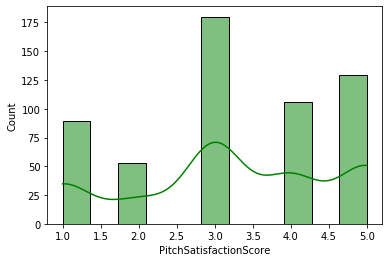

In [55]:
#PitchSatisfactionScore
sns.histplot(df_prodtaken_y['PitchSatisfactionScore'], kde=True, color='green')

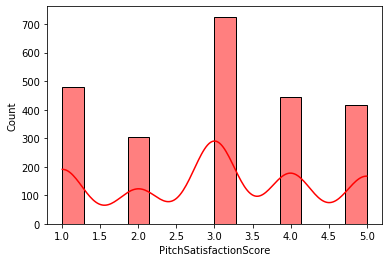

In [56]:
sns.histplot(df_prodtaken_n['PitchSatisfactionScore'], kde=True, color='red')

In [57]:
#PitchSatisfactionScore can be assumed to be roughly normal and independent of one another
#H0 : mean PitchSatisfactionScore is the same between package status
#H1 : mean PitchSatisfactionScore is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['PitchSatisfactionScore'], df_prodtaken_y['PitchSatisfactionScore'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[3.007594936708861, 3.238779174147217, 1.3522433077425087, 1.3405963251119408, 2370, 557]
-3.6562060886467576


In [58]:
#this is statistically significant so PitchSatisfaction Score is a factor

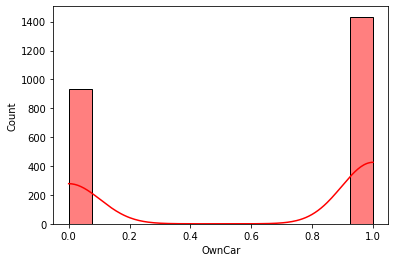

In [59]:
#OwnCar
sns.histplot(df_prodtaken_n['OwnCar'], kde=True, color='red')

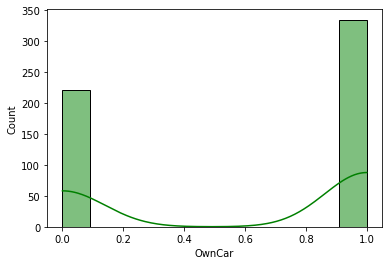

In [60]:
sns.histplot(df_prodtaken_y['OwnCar'], kde=True, color='green')

In [61]:
#OwnCar
#The two prop z can be used on OwnCar, npq>10 and binomial situation is '=1' success, 
# with '!=0' fail
#H0 : prop OwnCar is the same between package status 
#H1 : prop OwnCar different between package status
# significance = .05
OC = 'OwnCar'
nOC_is1, nOC_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[OC] != 1)]
nencode_OC = [1]*len(nOC_is1[OC])
nencode_OC.extend([0]*len(nOC_isnt1))
yOC_is1, yOC_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[OC] != 1)]
yencode_OC = [1]*len(yOC_is1[OC])
yencode_OC.extend([0]*len(yOC_isnt1))
twoprop_twotail_z(nencode_OC, yencode_OC, .05)

(-1.959963984540054, 1.959963984540054)
0.15752356652953106


In [62]:
#Car Ownership is not a factor

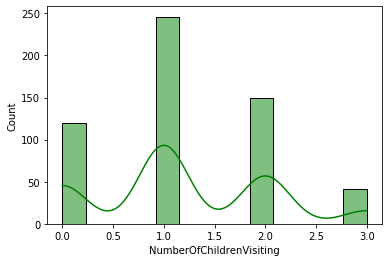

In [63]:
#NumberOfChildrenVisiting
sns.histplot(df_prodtaken_y['NumberOfChildrenVisiting'], kde=True, color='green')

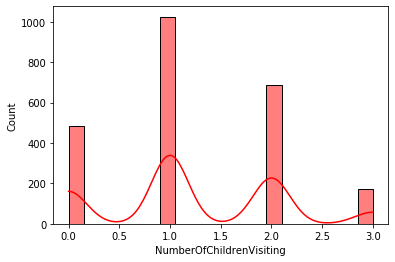

In [64]:
sns.histplot(df_prodtaken_n['NumberOfChildrenVisiting'], kde=True, color='r')

In [65]:
#NumberOfChildrenVisiting can be assumed to be roughly normal and independent of one another
#H0 : mean NumberOfChildrenVisiting is the same between package status
#H1 : mean NumberOfChildrenVisiting is different between package status
# significance = .05
nocv = 'NumberOfChildrenVisiting'
twos_twotail_ttest(df_prodtaken_n[nocv], df_prodtaken_y[nocv], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[1.230379746835443, 1.2010771992818672, 0.8565819601069663, 0.860273665760364, 2370, 557]
0.7239579535507047


In [66]:
#numbrer of children visiting is not a factor

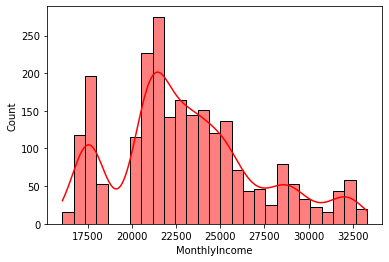

In [67]:
#MonthlyIncome
sns.histplot(df_prodtaken_n['MonthlyIncome'], kde=True, color='r')

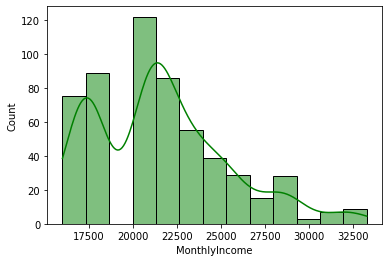

In [68]:
sns.histplot(df_prodtaken_y['MonthlyIncome'], kde=True, color='g')

In [ ]:
#MonthlyIncome
#The two prop z can be used on PPassport, npq>10 and binomial situation is '<26000' success, 
# with '!=0' fail
#H0 : prop Passport is the same between package status 
#H1 : prop Passport different between package status
# significance = .05
psp = 'Passport'
npsp_is1, npsp_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[psp] >= 26000)]
nencode_psp = [1]*len(npsp_is1[PPS])
nencode_psp.extend([0]*len(npsp_isnt1))
ypsp_is1, ypsp_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[psp] >= 26000)]
yencode_psp = [1]*len(ypsp_is1[PPS])
yencode_psp.extend([0]*len(ypsp_isnt1))
twoprop_twotail_z(nencode_psp, yencode_psp, .05)

In [69]:
#Hypothesis with Bivariate correlation